#                     Encoder-Only Transformer for Text Classification in PyTorch


# Setup & Imports


In [ ]:
# Basic imports
import torch
from torch import nn
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split, Dataset
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device config
device = torch.device("cpu")  # Force CPU usage

In [4]:
!pip uninstall -y torch torchvision torchaudio torchtext
!pip install torch==2.1.0+cpu torchvision==0.16.0+cpu torchaudio==2.1.0+cpu torchtext==0.16.0 -f https://download.pytorch.org/whl/cpu/torch_stable.html


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninstalled torchtext-0.18.0
Looking in links: https://download.pytorch.org/whl/cpu/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.9/184.9 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 38.3 MB/s eta 0:00:00


# Load & Prepare Data

In [2]:
# Tokenizer and vocabulary
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

train_iter = AG_NEWS(split='train')
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Define text and label pipelines
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1  # Labels 0-3


In [5]:
!pip install portalocker


In [8]:
!pip install --upgrade portalocker


# Collate Function & DataLoaders

In [3]:
def collate_batch(batch):
    label_list, text_list = [], []
    for label, text in batch:
        label_list.append(label_pipeline(label))
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)

    return torch.tensor(label_list, dtype=torch.int64).to(device), pad_sequence(text_list, batch_first=True).to(device)

# Reload iterators
train_iter, test_iter = AG_NEWS()
train_dataset = list(train_iter)
test_dataset = list(test_iter)

# Split train/val
train_len = int(0.95 * len(train_dataset))
valid_len = len(train_dataset) - train_len
train_data, valid_data = random_split(train_dataset, [train_len, valid_len])

# Dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)


In [18]:
len(train_dataset)

120000

In [19]:
len(test_dataset)

7600

# Positional Encoding Module

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


# Transformer Encoder-Only Model

In [5]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, emb_size=128, nhead=4, num_layers=2, dim_ff=256, dropout=0.1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, dropout)

        encoder_layers = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=dim_ff)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.fc = nn.Linear(emb_size, num_classes)
        self.emb_size = emb_size

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.emb_size)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output.mean(dim=1)
        return self.fc(output)


# Training & Evaluation Functions

In [6]:
def train_model(model, train_loader, valid_loader, epochs=5, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_acc, valid_acc = [], []
    for epoch in range(epochs):
        model.train()
        total_loss, correct, count = 0, 0, 0

        for labels, texts in train_loader:
            optimizer.zero_grad()
            output = model(texts)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (output.argmax(1) == labels).sum().item()
            count += labels.size(0)

        acc_train = correct / count
        acc_val = evaluate_model(model, valid_loader)
        train_acc.append(acc_train)
        valid_acc.append(acc_val)
        print(f"Epoch {epoch+1}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Loss={total_loss:.4f}")

    return train_acc, valid_acc

def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for labels, texts in dataloader:
            outputs = model(texts)
            predicted = outputs.argmax(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [8]:
!pip install numpy


In [19]:
!pip install numpy==1.26.4



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 91.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# Run Training

In [7]:
vocab_size = len(vocab)
num_classes = 4

model = TransformerClassifier(vocab_size=vocab_size, num_classes=num_classes).to(device)
train_acc, val_acc = train_model(model, train_loader, valid_loader, epochs=5,lr = 0.001)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1: Train Acc=0.7359, Val Acc=0.8575, Loss=1217.8813
Epoch 2: Train Acc=0.8688, Val Acc=0.8805, Loss=697.0129
Epoch 3: Train Acc=0.8935, Val Acc=0.9027, Loss=570.8696
Epoch 4: Train Acc=0.9073, Val Acc=0.9055, Loss=498.4429
Epoch 5: Train Acc=0.9166, Val Acc=0.9063, Loss=451.6589


# Plot Accuracy

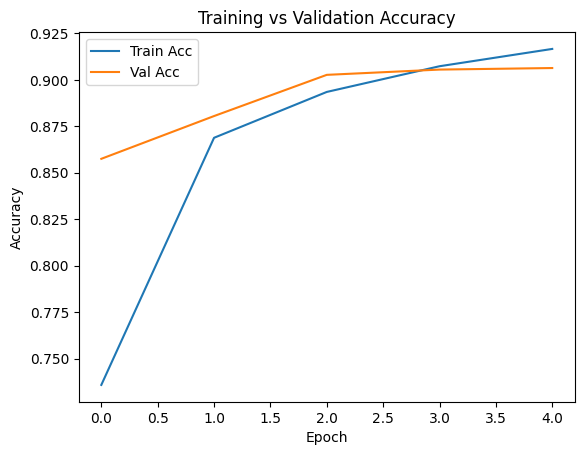

In [8]:
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


# Final Evaluation & Inference

In [9]:
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

def predict(text):
    model.eval()
    with torch.no_grad():
        text_tensor = torch.tensor(text_pipeline(text)).unsqueeze(0).to(device)
        output = model(text_tensor)
        return output.argmax(1).item()

labels = ["World", "Sports", "Business", "Sci/Tec"]
sample_text = "NASA is launching a new satellite for climate research"
pred = predict(sample_text)
print(f"Predicted Class: {labels[pred]}")


Test Accuracy: 0.9053
Predicted Class: Sci/Tec


In [13]:
def predict(text):
    model.eval()
    with torch.no_grad():
        text_tensor = torch.tensor(text_pipeline(text)).unsqueeze(0).to(device)
        output = model(text_tensor)
        return output.argmax(1).item()

labels = ["World", "Sports", "Business", "Sci/Tec"]
sample_text = "He is going to start a new job to collect money for business purpose"
pred = predict(sample_text)
print(f"Predicted Class: {labels[pred]}")

Predicted Class: Business


In [14]:
def predict(text):
    model.eval()
    with torch.no_grad():
        text_tensor = torch.tensor(text_pipeline(text)).unsqueeze(0).to(device)
        output = model(text_tensor)
        return output.argmax(1).item()

labels = ["World", "Sports", "Business", "Sci/Tec"]
sample_text = "Pakistan win world cup in 1992"
pred = predict(sample_text)
print(f"Predicted Class: {labels[pred]}")

Predicted Class: Sports
